## Instruções
- Redes Neuronais + Backpropagation

Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função Sigmóide para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte:

![title](formula.jpg)

onde m é a quantidade de entradas no treino, K é o número de saídas possíveis,  representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

# Resolução

Para esse trabalho prático utilizarei a biblioteca KERAS para criar o modelo de rede neuronal proposto. Além disso, usaremos a biblioteca numpy e pandas para tratar dados vetoriais e para plotar gráficos dos resultados obtidos.

Os comentários e conclusões estão presentes juntamente com o código desse notebook.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras import optimizers
import numpy
import keras

# fix random seed for reproducibility
numpy.random.seed(7)

/home/lfmendes/data/mestrado/machine-learning/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Carregando Arquivo
Carregando o arquivo com os 5000 digitos e dividindo em X (matrix com as features) e y (vetor com as respostas)

Além disso, definimos o número de categorias(classes) baseados no y e o número de pixels

In [2]:
# load pima indians dataset
dataset = numpy.loadtxt("/home/lfmendes/data/mestrado/machine-learning/ml-neural/data_tp1.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,1:]
y = dataset[:,0]

y_cat = np_utils.to_categorical(y)
num_classes = y_cat.shape[1]

num_pixels = 784

print("Número de entradas: %s" % (len(y)))
print("Número de features: %s" % (len(X[0])))
print("Número de classes: %s" % (num_classes))

Número de entradas: 5000
Número de features: 784
Número de classes: 10


## Código para criação do modelo dado os parâmetros que podem ser variados

A função a seguir irá definir o modelo que será utilizado, dando espaço para modificar os parâmetros pedidos, no caso definimos os seguintes parâmetros:

* learning_rate - Taxa de aprendizado
* neuronios_ocultos - Quantidade de neuronios na camada oculta

O modelo a ser cosntruído é composto de
* uma camada de entrada com 784 neuronios e utiliza a função de ativação 'relu'.
* uma camada oculta com o número de neurônios parametrizada pela função
* uma camada de saída com número de neurônios igual ao número de classes, nesse caso utilizamos a função softmax 

Para fazer a otimização do modelo, estamos usando um SGD com learning rate definido no parâmetro da função. Importante salientar que durante o **fit** se utilizarmos o SGD com batch size igual a 1 ele se comporta como Stochastic Gradient Descent (o gradiente é calculado após cada entrada), se usarmos o batch size igual ou maior ao tamanho do treino ele se comporta como Gradient Descent (o gradiente é calculado após cada época) e nos outros casos ele funciona como Mini-Batch: o gradiente é calculado após um certo número de entradas.

A função de perda utilizada é a **categorical_crossentropy** e a métrica utilizada é a **acurácia**.

![alt text](rede.png "Desenho da Rede")

In [3]:
def create_model(learning_rate=0.5,neuronios_ocultos=25):
    # create model   
    model = Sequential()
    model.add(Dense(num_pixels, activation='relu', input_shape=(784,)))
    model.add(Dense(neuronios_ocultos, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    sgd = optimizers.SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
   
    return model

## Fazendo experimentação
Dividindo em treino e teste usando 5 kfolds.

Na próxima célula definimos uma função que separa em folds, sendo que para isso ela aleatoriza a entrada e utiliza uma semente aleatória. Além disso, por estarmos utilizando a função **StratifiedKFold** da biblioteca **sklearn** então os folds irão ser criados de forma a respeitar a dsitribuição de classes da entrada

Já a função **experimentation()** é a principal desse trabalho, nela fazemos 
* a divisão de folds da entrada
* o tratamento da entrada, passando os valores brutos para floats 
* transformamos nossa entrada em vetorial ou categórica, isto é, um valor como 2 vira [0,1,0,0,0,0,0,0,0,0]
* Criamos o modelo como já definido na função **create_model()**
* Fazemos o fit desse modelo utilizando apenas os dados de treino
* Calculamos e guardamos a acurácia obtida nos dados de teste

In [4]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fold_size = 5

def get_folds(seed,fold_size=5):    
    return StratifiedKFold(n_splits=fold_size, random_state=seed,shuffle=True)

def experimentation(batch_size=5000,learning_rate=0.5,neuronio=100,epochs=250,seed=42, verbose=0):    
    fold = 0
    avg_error = 0.0
    avg_acc = 0.0
    first = True
    accs = []
    
    skf = get_folds(seed)
    
    for train_index, test_index in skf.split(X, y):
        print("Fazendo teste nos fold " + str(fold))
        if(verbose > 0):            
            print("batch_size: " + str(batch_size))
            print("learning_rate: " + str(learning_rate))
            print("neuronio: " + str(neuronio))
            print("epochs: " + str(epochs))

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape(len(train_index), 784)
        X_test = X_test.reshape(len(test_index), 784)
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train /= 255
        X_test /= 255
        
        if(verbose > 0):
            print(X_train.shape[0], 'train samples')
            print(X_test.shape[0], 'test samples')

        y_train = np_utils.to_categorical(y_train)
        y_test = np_utils.to_categorical(y_test)   
        
        if(verbose > 0):
            print('Distribuicao no treino: ' + str(y_train.sum(axis=0, dtype='float')))
            print('Distribuicao no test: ' + str(y_test.sum(axis=0, dtype='float')))

        model=create_model(learning_rate=learning_rate,neuronios_ocultos=neuronio)
        
        if((verbose > 0) and first):
            model.summary()
            first = False

        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=epochs, batch_size=batch_size, verbose=verbose,
                  shuffle=True)

        # Final evaluation of the model        
        if(verbose > 0):
            # Avaliando no Treino (verificar caso de overfitting)
            scores = model.evaluate(X_train, y_train, verbose=1)
            print("Resultado no Treino")
            print("Baseline Error: %.2f%%" % (100-scores[1]*100))
            print("%s: %.2f%%\n" % (model.metrics_names[1], scores[1]*100))
        
        # Avaliando o Teste
        scores = model.evaluate(X_test, y_test, verbose=verbose)        
        if(verbose > 0):
            print("Resultado no Teste")
            print('Distribuicao na predicao: ' + str(model.predict(X_test).sum(axis=0, dtype='float')))
            print("Baseline Error: %.2f%%" % (100-scores[1]*100))
            print("%s: %.2f%%\n\n" % (model.metrics_names[1], scores[1]*100))
        
        avg_acc = avg_acc + scores[1]*100
        accs.append(scores[1]*100) 

        fold=fold+1

    print(avg_acc/fold_size) 
    print(accs)
    print('\n\n   ---------------------  \n\n')
    return accs

## Definindo parâmetros de teste

Para realizar os testes requisitados no trabalho, vamos definir alguams variáveis contendo os valores possíveis para cada parâmetro.

* batch size - Variando entre um SGD puro e o Gradient Descent
* learning rate - Variando as taxas de aprendizado
* neuronios - Variando a quantidade de neurônios na camada oculta
* epochs - Variando a quantidade de épocas 

Além disso, definimos 5 sementes para serem utilizadas durante a experimentação, sendo assim para cada valor de parâmetro teremos 25 resultados sendo 5 de cada fold para cada semente. Isto foi feito para aproximarmos melhor dos valores reais.

In [5]:
batch_sizes=[1,10,50,5000]
learning_rates=[0.5, 1, 10]
neuronios=[25,50,100]
epochs_variations=[20,100,250,500]

# Seeds utilizadas para rodar vários experimentos e termos um valor mais aproximado do "real"
iterations=[120,1111,422,122,8999]

## Visualizando o resultado

Para facilitar as conclusões vamos definir uma função que mostra o histograma com as médias para cada parâmetro e o boxplot com esses valores

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def print_results(results):
    df = pd.DataFrame(results)
    print(df)
    plt.bar(list(df.mean().keys()), df.mean(), color='g')
    plt.show()
    df.boxplot()

## Experimentando com batch size

O objetivo desses experimentos é verificar qual o impacto do batch_size no resultado. 

Nesse caso estamos realizando os seguintes experimentos

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

In [7]:
batches_results = {}
for batch in batch_sizes:
    print('Experimentando com batch size igual a ' + str(batch))
    print('\n\n')
    batches_results[str(batch)] = []
    for it in iterations: 
        batches_results[str(batch)].extend(experimentation(batch_size=batch,seed=it))
    print(batches_results)     

Experimentando com batch size igual a 1



Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
10.619895341334654
[11.465603190428714, 9.190809191553505, 10.410410419360057, 11.411411420361057, 10.62124248496994]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
10.37905473768198
[11.465603193400034, 10.389610390354703, 10.01001001001001, 10.010010014484832, 10.02004008016032]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
9.879911845717555
[9.970089733778895, 9.990009990754304, 9.20920920920921, 10.210210214685034, 10.02004008016032]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
10.099772666323

Agora para visualizar melhor os resultados vamos plotar um histograma com as médias de cada valor e depois um boxplot para termos uma noção da variação do resultado

            1         10         50       5000
0   11.465603  10.269192  94.117647  92.422732
1    9.190809   9.290709  93.106893  92.107892
2   10.410410  18.418418  94.794795  93.393393
3   11.411411   9.209209  93.393393  92.792793
4   10.621242  10.020040  95.591182  94.088176
5   11.465603   9.770688  92.821535  92.323031
6   10.389610  10.389610  93.106893  91.808192
7   10.010010  10.410410  96.196196  94.294294
8   10.010010   9.109109  95.095095  93.293293
9   10.020040  10.220441  94.388778  93.086172
10   9.970090  10.269192  94.815553  94.017946
11   9.990010   9.290709  94.105894  93.406593
12   9.209209  10.010010  93.893894  92.292292
13  10.210210   9.109109  93.593594  93.593594
14  10.020040  10.420842  94.689379  93.186373
15  10.269192   9.272183  93.818544  92.123629
16  10.389610   9.990010  93.606394  92.607393
17  10.410410  10.010010   9.809810  91.691692
18   9.209209  11.411411   9.809810  93.193193
19  10.220441  11.422846  95.390782  94.188377
20  10.269192

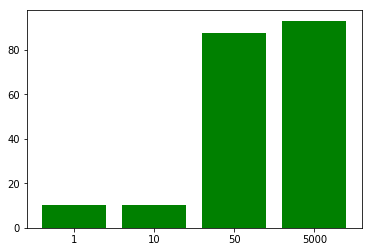

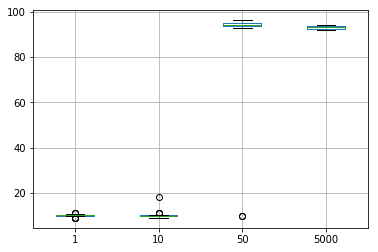

In [8]:
print_results(batches_results)

## Resultados do experimento com batch size

É fácil notar pelo gráfico que batch size......

## Experimentando com learning_rates

O objetivo desses experimentos é avaliar qual o impacto da taxa de aprendizado.
Nesse caso vamos testar as seguintes taxas de aprendizado: [0.5, 1, 10]

In [9]:
learning_rates_results = {}
for learning_rate in learning_rates:
    print('Experimentando com learning rate igual a ' + str(learning_rate))
    print('\n\n')
    learning_rates_results[str(learning_rate)] = []
    for it in iterations: 
        learning_rates_results[str(learning_rate)].extend(experimentation(learning_rate=learning_rate, seed=it))
    print(learning_rates_results)     

Experimentando com learning rate igual a 0.5



Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
93.26125796077858
[92.42273183429943, 92.5074925074925, 93.7937937937938, 92.89289291079218, 94.68937875751503]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
93.04071696878694
[92.6221335992024, 92.00799200799202, 94.29429429429429, 93.39339339935982, 92.88577154308616]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
93.15935956239912
[94.01794616151545, 93.10689311880212, 92.09209209209209, 93.29329329329329, 93.28657314629258]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
92.84069670984839
[9

          0.5          1         10
0   92.422732  93.519442  10.368893
1   92.507493  93.106893  10.589411
2   93.793794  93.293293  10.010010
3   92.892893  92.492493  10.410410
4   94.689379  94.388778  10.420842
5   92.622134  92.323031   9.770688
6   92.007992  93.006993   9.990010
7   94.294294  95.095095  10.210210
8   93.393393  94.094094   9.809810
9   92.885772  93.587174  10.420842
10  94.017946  94.317049   9.970090
11  93.106893  94.505495  10.289710
12  92.092092  92.992993  11.411411
13  93.293293  93.293293   9.209209
14  93.286573  94.288577  10.621242
15  92.323031  92.522433   9.272183
16  92.507493  93.306693   9.290709
17  92.692693  93.093093  10.610611
18  93.093093  94.394394  11.411411
19  93.587174  94.589178  11.422846
20  92.721835  93.120638   9.172483
21  93.906094  94.605395   9.990010
22  93.693694  95.095095  10.210210
23  92.992993  93.293293  10.010010
24  93.186373  93.687375  11.422846


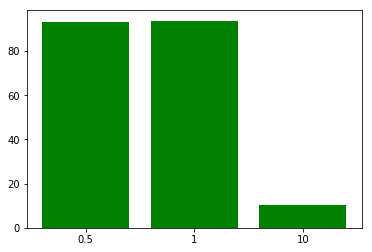

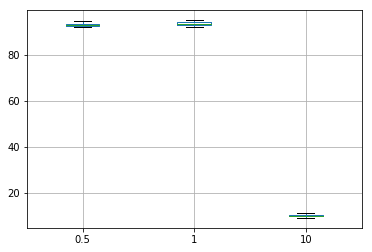

In [10]:
print_results(learning_rates_results)

## Resultados do experimento com learning rate

É fácil notar pelo gráfico que learning rate......

## Experimentando com neuronios na camada oculta

O objetivo desses experimentos é avaliar qual o impacto do número de neurônios na camada oculta.

In [11]:
neuronios_results = {}
for neuronio in neuronios:
    print('Experimentando com learning rate igual a ' + str(neuronio))
    print('\n\n')
    neuronios_results[str(neuronio)] = []
    for it in iterations: 
        neuronios_results[str(neuronio)].extend(experimentation(neuronio=neuronio,seed=it))
    print(neuronios_results)     

Experimentando com learning rate igual a 25



Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
93.06075761919848
[92.5224327316075, 92.8071928071928, 92.7927927927928, 92.99299301089229, 94.18837675350701]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
93.10139613245772
[92.02392821535393, 91.70829170829171, 94.69469469469469, 94.09409410006052, 92.98597194388778]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
92.98007784802329
[93.02093718843469, 92.90709291900193, 92.7927927927928, 92.7927927927928, 93.3867735470942]


   ---------------------  


Fazendo teste nos fold 0
Fazendo teste nos fold 1
Fazendo teste nos fold 2
Fazendo teste nos fold 3
Fazendo teste nos fold 4
92.74111601386052
[91.72

          100         25         50
0   92.422732  92.522433  92.721835
1   92.407592  92.807193  92.607393
2   93.493493  92.792793  93.293293
3   92.792793  92.992993  92.892893
4   94.188377  94.188377  94.589178
5   91.924227  92.023928  91.525424
6   92.007992  91.708292  92.407592
7   94.994995  94.694695  94.394394
8   93.293293  94.094094  93.293293
9   93.587174  92.985972  93.587174
10  93.619143  93.020937  93.519442
11  93.006993  92.907093  93.506494
12  92.892893  92.792793  92.692693
13  93.193193  92.792793  92.892893
14  93.186373  93.386774  93.787575
15  92.023928  91.724826  92.921236
16  92.507493  92.707293  92.607393
17  92.292292  92.092092  92.592593
18  93.893894  92.992993  93.293293
19  94.488978  94.188377  94.488978
20  91.924227  92.223330  92.622134
21  93.506494  93.706294  94.005994
22  94.194194  93.393393  93.393393
23  92.192192  91.891892  92.192192
24  92.985972  93.286573  93.687375


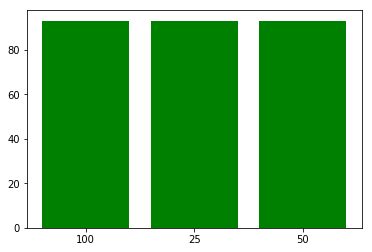

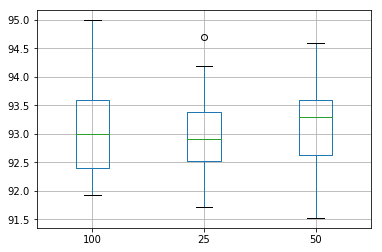

In [12]:
print_results(neuronios_results)

## Resultados do experimento com neuronios na camada oculta

É fácil notar pelo gráfico que batch size......

## Variando o número de camadas ocultas para cada gradiente

In [13]:
import itertools

neuroniosXbatch_results = {}
for x in itertools.product(batch_sizes, neuronios):    
    neuronio = x[1]
    batch = x[0]
    print('Experimentando com  (batch,neuronio)' + str(x))
    print('\n\n')
    neuroniosXbatch_results[str(x)] = []    
    neuroniosXbatch_results[str(neuronio)].extend(experimentation(neuronio=neuronio,batch_size=batch))
    print(neuroniosXbatch_results)    

Experimentando com  (batch,neuronio)(1, 25)





KeyError: '25'

In [ ]:
print_results(neuroniosXbatch_results)

# Ao final testar

* Rodar uma vez com 70-30 e a melhor opção de parâmetros encontrados
* * mostrar o historico por epoch
* Adicionar dropout e verificar se o resultado melhor
* * mostrar o treino vs teste nesse caso
* conclusão